# Étape 1 – Import des bibliothèques

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno


# Étape 2 – Chargement du jeu de données

In [14]:
df = pd.read_csv("dataset.csv")
df.head()

,nom,prenom,age,taille,poids,sexe,sport_licence,niveau_etude,region,smoker,nationalité_francaise,revenu_estime_mois,situation_familiale,historique_credits,risque_personnel,date_creation_compte,score_credit,loyer_mensuel,montant_pret
0,Ramirez,Casey,73,161.1,67.3,H,non,master,Occitanie,non,oui,857,célibataire,NaN,0.11,2024-09-28,615.0,1377.97,13157.101646
1,Hill,Phillip,44,168.2,74.9,H,non,bac,Île-de-France,non,oui,5245,célibataire,2.0,0.79,2023-06-26,NaN,10000.00,32408.309272
2,Hernandez,Martin,71,160.3,45.5,H,non,doctorat,Auvergne-Rhône-Alpes,oui,oui,3792,célibataire,0.0,0.13,2023-06-13,NaN,5000.00,17975.461375
3,Miller,Michael,62,161.9,87.7,F,oui,bac,Auvergne-Rhône-Alpes,oui,oui,3291,divorcé,NaN,0.32,2024-01-12,NaN,10000.00,16004.737731
4,Walker,Matthew,18,178.0,77.6,F,oui,bac,Corse,non,oui,3893,célibataire,NaN,0.66,2023-02-16,NaN,NaN,10437.682760


# Étape 3 – Analyse des valeurs manquantes

In [15]:
# Suppression des doublons
df = df.drop_duplicates()
# Colonnes avec des valeurs manquantes
df.isnull().sum().sort_values(ascending=False)


score_credit             5306
historique_credits       5293
loyer_mensuel            2906
situation_familiale      2352
age                         0
nom                         0
prenom                      0
taille                      0
poids                       0
sexe                        0
sport_licence               0
nationalité_francaise       0
smoker                      0
region                      0
niveau_etude                0
risque_personnel            0
revenu_estime_mois          0
date_creation_compte        0
montant_pret                0
dtype: int64

<Axes: >

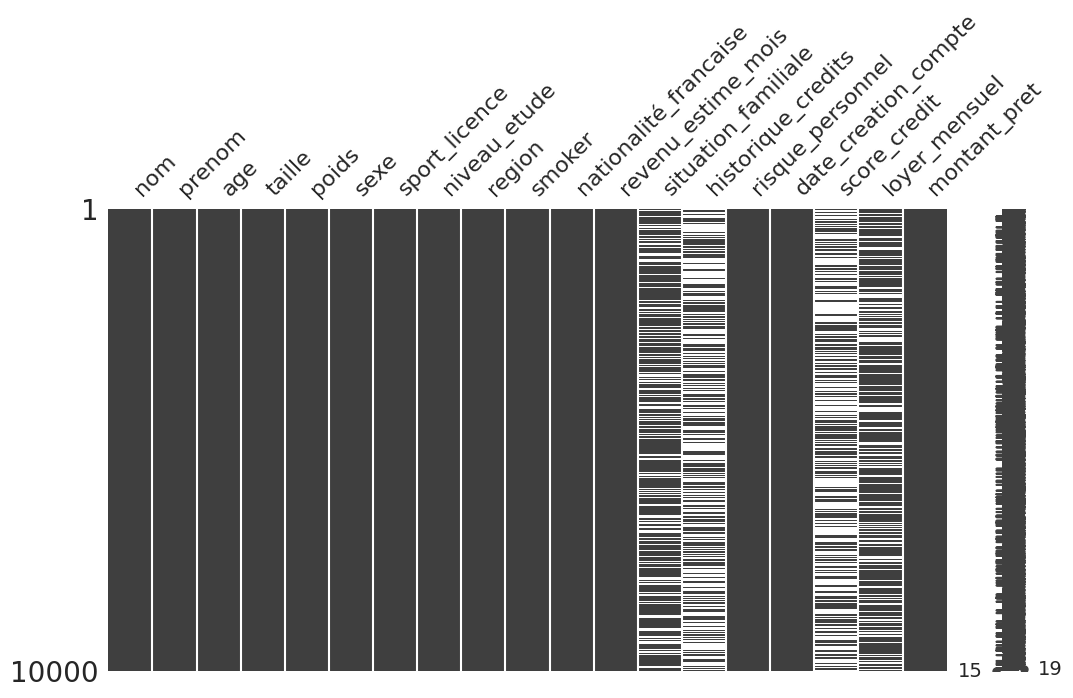

In [16]:
# Visualisation avec missingno
msno.matrix(df, figsize=(12,6))

# Etape 4 - Nettoyage et traitement

### 1. Suppression des colonnes quasi-vides (plus de 90% de valeurs manquantes)

In [17]:
seuil_colonnes_vides = 0.90
colonnes_a_supprimer = df.columns[df.isnull().mean() > seuil_colonnes_vides]
df.drop(columns=colonnes_a_supprimer, inplace=True)

print(f"Colonnes supprimées (>{int(seuil_colonnes_vides*100)}% de valeurs manquantes) : {list(colonnes_a_supprimer)}")

Colonnes supprimées (>90% de valeurs manquantes) : []


### 2. Suppression des lignes trop incomplètes (plus de 50% de valeurs nulles ou selon seuil)

In [18]:
# ➤ 2. Suppression des lignes trop incomplètes (plus de 50% de valeurs nulles ou selon seuil)
seuil_lignes = 0.5
lignes_avant = df.shape[0]
df = df[df.isnull().mean(axis=1) < seuil_lignes]
lignes_apres = df.shape[0]

print(f"Lignes supprimées : {lignes_avant - lignes_apres} (incomplètes à plus de {int(seuil_lignes*100)}%)")

Lignes supprimées : 0 (incomplètes à plus de 50%)


### 3. Détection et traitement des outliers avec IQR (remplacement par borne)

In [19]:
colonnes_numeriques = df.select_dtypes(include=["float", "int"]).columns

for col in colonnes_numeriques:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower) | (df[col] > upper)][col]

    if not outliers.empty:
        df[col] = np.where(df[col] < lower, lower, df[col])
        df[col] = np.where(df[col] > upper, upper, df[col])
        print(f"{col} : {len(outliers)} outliers remplacés par bornes IQR")

taille : 57 outliers remplacés par bornes IQR
poids : 56 outliers remplacés par bornes IQR
revenu_estime_mois : 41 outliers remplacés par bornes IQR
montant_pret : 103 outliers remplacés par bornes IQR


score_credit             5306
historique_credits       5293
loyer_mensuel            2906
situation_familiale      2352
age                         0
nom                         0
prenom                      0
taille                      0
poids                       0
sexe                        0
sport_licence               0
nationalité_francaise       0
smoker                      0
region                      0
niveau_etude                0
risque_personnel            0
revenu_estime_mois          0
date_creation_compte        0
montant_pret                0
dtype: int64

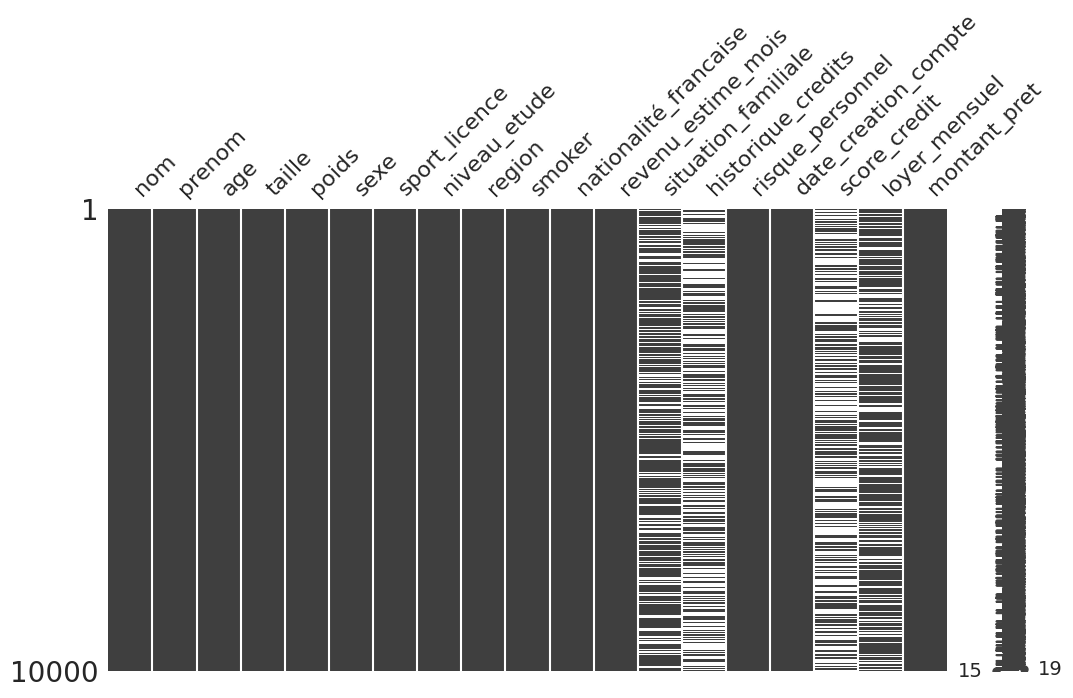

In [20]:
# Visualisation avec missingno
msno.matrix(df, figsize=(12,6))
# Colonnes avec des valeurs manquantes
df.isnull().sum().sort_values(ascending=False)

### 4. Imputation des valeurs manquantes selon stratégie par variable


historique_credits : valeurs nulles imputées par médiane
loyer_mensuel : valeurs nulles imputées par médiane
Imputation par KNN effectuée sur : 
['revenu_estime_mois', 'montant_pret', 'score_credit']
'situation_familiale': Le remplissage des valeurs nulles a été fait par le mode (valeur : 'marié').


nom                      0
prenom                   0
age                      0
taille                   0
poids                    0
sexe                     0
sport_licence            0
niveau_etude             0
region                   0
smoker                   0
nationalité_francaise    0
revenu_estime_mois       0
situation_familiale      0
historique_credits       0
risque_personnel         0
date_creation_compte     0
score_credit             0
loyer_mensuel            0
montant_pret             0
dtype: int64

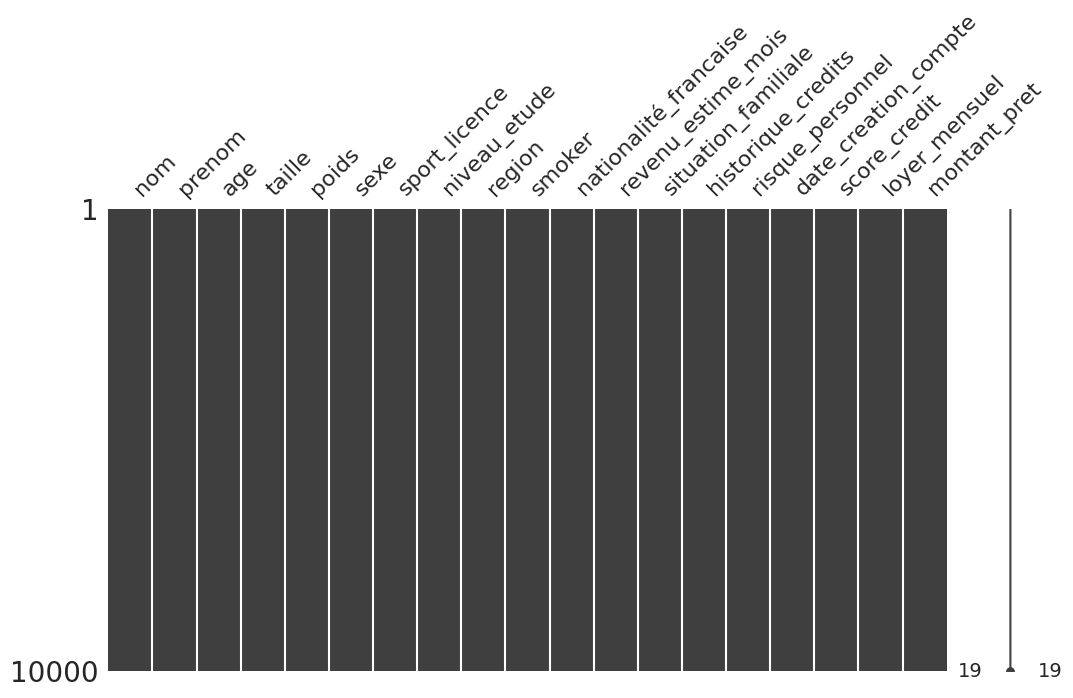

In [21]:
from sklearn.impute import KNNImputer
colonnes_numeriques_peu_correlees= ["historique_credits","loyer_mensuel"]
colonnes_numeriques_correlees= ["revenu_estime_mois", "montant_pret", "score_credit"]
colonne_categorielle = "situation_familiale"
# Remplissage par médiane pour les colonnes numériques peu corrélées
for col in colonnes_numeriques_peu_correlees:
    if df[col].isnull().sum() > 0:
        df[col] = df[col].fillna(df[col].median())
        print(f"{col} : valeurs nulles imputées par médiane")

# Exemple avec KNNImputer pour certaines colonnes numériques corrélées
imputer = KNNImputer(n_neighbors=5)
df[colonnes_numeriques_correlees] = imputer.fit_transform(
    df[colonnes_numeriques_correlees]
)
print("Imputation par KNN effectuée sur : ")
print(colonnes_numeriques_correlees)

#Pré remplissage de la situation familiale
if df[colonne_categorielle].isnull().sum() > 0:
    # Calcul du mode (la valeur la plus fréquente)
    mode_valeur = df[colonne_categorielle].mode()[0]

    # Remplissage des NaN avec le mode
    df[colonne_categorielle] = df[colonne_categorielle].fillna(mode_valeur)
    print(f"'{colonne_categorielle}': Le remplissage des valeurs nulles a été fait par le mode (valeur : '{mode_valeur}').")

# Visualisation avec missingno
msno.matrix(df, figsize=(12,6))
# Colonnes avec des valeurs manquantes
df.isnull().sum().sort_values(ascending=False)

In [24]:
#Résumé statistique après nettoyage
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,10000.0,46.516500,16.832845,18.00,32.00,46.000000,61.000000,75.000000
taille,10000.0,170.007710,9.953957,142.80,163.20,170.100000,176.800000,197.200000
poids,10000.0,70.063940,14.909513,29.05,59.80,70.200000,80.300000,111.050000
revenu_estime_mois,10000.0,2519.529150,1153.097761,500.00,1683.00,2480.000000,3304.000000,5735.500000
historique_credits,10000.0,2.785100,1.182395,0.00,3.00,3.000000,3.000000,5.000000
risque_personnel,10000.0,0.499094,0.290107,0.00,0.24,0.500000,0.750000,1.000000
score_credit,10000.0,573.428880,121.228382,300.00,496.20,575.500000,647.800000,849.000000
loyer_mensuel,10000.0,5124.777104,3159.929293,-395.25,5000.00,5000.000000,5000.000000,10000.000000
montant_pret,10000.0,9111.349464,10665.322827,500.00,500.00,3600.605667,16245.534725,39863.836812


# Etape 5 - Génération du dataset nettoyé

In [23]:
df.to_csv('dataset_clean_sans_ethics.csv', index=False)